In [55]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

CUSTOM_SEED = 42
np.random.seed(CUSTOM_SEED)

In [2]:
# read in data
df = pd.read_pickle('../data/corpus.pkl')
data = pd.read_pickle('../data/data_df.pkl')

In [ ]:
# split syllables column up for ease of use in get_features
df['syllables'] = df.syllables.str.split(' ')

In [50]:
df.loc[1:1]

,word,pos,syllables,word_vec,syllable_vec
1,ἀείδειν,v--pna---,"[ἀ, εί, δειν]","[0.17073170731707318, 0.032520325203252036, 0....","[0.0004017677782241864, 0.08798714343109683, 0..."


In [78]:
new = list(set(df.pos.str.slice(0,1)))

In [79]:
new

['t', 'm', 'r', 'n', 'v', 'p', 'e', 'l', 'd', 'x', 'c', 'a', 'g', '-']

In [80]:
##test
ohe = OneHotEncoder()
lb = LabelBinarizer()

In [81]:
lb.fit(new)

LabelBinarizer()

In [85]:
lb.transform(df.pos.values[0][1])

ValueError: Expected array-like (array or non-string sequence), got '-'

In [82]:
lb.classes_

array(['-', 'a', 'c', 'd', 'e', 'g', 'l', 'm', 'n', 'p', 'r', 't', 'v',
       'x'], dtype='<U1')

In [ ]:
# get features as a dict to pass to DictVectorizer
def get_features(word):
    return {
        'characters': len(word[0]),    # character count
        'syllable_count': len(word[2])    # cout of syllables
    }

# get target as a dict to pass to DictVectorizer, or LabelEncoder
def get_targets(word):
    return {
        'pos': word[1][0],    # 
#         'person': word[1][1],
#         'number': word[1][2],
#         'tense': word[1][3],
#         'mood': word[1][4],
#         'voice': word[1][5],
#         'gender': word[1][6],
#         'case': word[1][7],
#         'degree': word[1][8],
    }

# small function to make an array out of the nested lists pandas spits out
def make_array(to_arrayify):
    return np.array([np.array(i).astype('float64') for i in to_arrayify])
        

In [6]:
# make tuples out of the columns I want to use and pass to get_features, get_targets etc.
words = [tuple((df.word[i],df.pos[i],df.syllables[i])) for i in range(len(df))]

# Getting Features

In [7]:
# make a list features dicts
features = [get_features(word) for word in words]

# instantiate DictVectorizer
feature_vectorizer = DictVectorizer(sparse=False)

# fit the vectorizer on the dicts and then transform the features into vectors
features = feature_vectorizer.fit_transform(features)


In [8]:
print(f'Shape = {features.shape}')
print(f'\nDictVectorizer Output = {features[0]}')
print(f'\nRange of DictVectorizer values = {feature_vectorizer.feature_names_}')

Shape = (42070, 2)

DictVectorizer Output = [7. 3.]

Range of DictVectorizer values = ['characters', 'syllable_count']


In [9]:
# transforming back from feature_vectorizer
feature_vectorizer.inverse_transform(np.reshape(features[0], (1,-1)))

[{'characters': 7.0, 'syllable_count': 3.0}]

In [10]:
# make arrays from the dataframe. These vectors were obtained through tensorflow tokenizer
word_vecs = make_array(df.word_vec.values)
print(f'word_vecs shape = {word_vecs.shape}')

syllable_vecs = make_array(df.syllable_vec.values)
print(f'\nsyllable_vecsShape = {syllable_vecs.shape}')

word_vecs shape = (42070, 18)

syllable_vecsShape = (42070, 8)


In [11]:
# concat the word vectors, syllable vectors, and the features into one vector
X = np.concatenate((word_vecs, 
                    syllable_vecs, 
#                     features
                   ), 
                   axis=1)
print(f'Output = {X[0]}')
print(f'Shape = {features.shape}')

Output = [0.13821138 0.15447154 0.08130081 0.23577236 0.04878049 0.15447154
 0.06504065 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.03856971 0.02631579 0.3852953  0.         0.         0.
 0.         0.        ]
Shape = (42070, 2)


In [12]:
X[0].shape

(26,)

# Getting Targets - DictVectorizer

In [13]:
# make a list target dicts
targets = [get_targets(word) for word in words]

# instantiate DictVectorizer
target_vectorizer = DictVectorizer(sparse=False)

# fit the vectorizer on the dicts and then transform the targets into vectors
y = target_vectorizer.fit_transform(targets)

In [14]:
# DictVectorizer range:
target_vectorizer.feature_names_

['pos=-',
 'pos=a',
 'pos=c',
 'pos=d',
 'pos=e',
 'pos=g',
 'pos=l',
 'pos=m',
 'pos=n',
 'pos=p',
 'pos=r',
 'pos=t',
 'pos=v',
 'pos=x']

In [15]:
len(y[0])

14

In [16]:
# transforming back from target_vectorizer
target_vectorizer.inverse_transform(y[0].reshape((1,-1)))

[{'pos=n': 1.0}]

# Getting Targets - LabelEncoder

In [17]:
# instantiate LabelEncoder
target_encoder = LabelEncoder()

# fit and transform on the target data
y2 = target_encoder.fit_transform(df.pos.values)

In [18]:
y2[0]

188

In [19]:
# transform back from target_encoder
target_encoder.inverse_transform(np.ravel(y2[1]))

array(['v--pna---'], dtype=object)

-------------


In [20]:
tk_words = Tokenizer(num_words=None,
               char_level=True, 
               oov_token='-OOV-'
              )

In [21]:
tk_words.fit_on_texts(df.word.values)

In [22]:
seq_words = tk_words.texts_to_sequences(df.word.values)
# test_seq_words = tk_words.texts_to_sequences(X_test.word.values)

In [23]:
tk_pos = Tokenizer(num_words=None,
               char_level=True, 
               oov_token='-OOV-'
              )
tk_pos.fit_on_texts(df.pos.values)

In [24]:
seq_pos = tk_words.texts_to_sequences(df.pos.values)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(seq_words,
                                                    seq_pos,
                                                    test_size=.3
                                                   )

In [26]:
maxlen = len(max(seq_words, key=len))
print(maxlen)  # 271

18


In [27]:
X_train = pad_sequences(X_train, maxlen=maxlen, padding='post')
X_test = pad_sequences(X_test, maxlen=maxlen, padding='post')
y_train = pad_sequences(y_train, maxlen=maxlen, padding='post')
y_test = pad_sequences(y_test, maxlen=maxlen, padding='post')

In [28]:

y_test[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [29]:
X_test[0]

array([45, 13,  3, 25, 29,  9,  5,  4,  6,  0,  0,  0,  0,  0,  0,  0,  0,
        0], dtype=int32)

In [30]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(29449, 18)
(12621, 18)
(29449, 18)
(12621, 18)


In [35]:
word2index = tk_words.word_index
word2index['-PAD-'] = 0  # The special value used for padding

tag2index = tk_pos.word_index
tag2index['-PAD-'] = 0  # The special value used to padding

In [36]:
def to_categorical(sequences, categories):
    cat_sequences = []
    for s in sequences:
        cats = []
        for item in s:
            cats.append(np.zeros(categories))
            cats[-1][item] = 1.0
        cat_sequences.append(cats)
    return np.array(cat_sequences)

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation
from tensorflow.keras.optimizers import Adam
 
model = Sequential() 
model.add(InputLayer(input_shape=(maxlen,)))
model.add(Embedding(len(word2index), 18))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(len(tag2index))))
model.add(Activation('softmax'))
 
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])
 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 18, 18)            2232      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 18, 512)           563200    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 18, 23)            11799     
_________________________________________________________________
activation_1 (Activation)    (None, 18, 23)            0         
Total params: 577,231
Trainable params: 577,231
Non-trainable params: 0
_________________________________________________________________


In [38]:
hist = model.fit(X_train, to_categorical(y_train, len(tag2index)), epochs=1)

921/921 [==============================] - 43s 46ms/step - loss: 0.0326 - accuracy: 0.9981


In [39]:
def logits_to_tokens(sequences, index):
    token_sequences = []
    for categorical_sequence in sequences:
        token_sequence = []
        for categorical in categorical_sequence:
            token_sequence.append(index[np.argmax(categorical)])
 
        token_sequences.append(token_sequence)
 
    return token_sequences

In [45]:
predict = model.predict(X_train[0])

In [49]:
print(logits_to_tokens(predict, {i: t for t, i in tag2index.items()}))

[['-PAD-'], ['-OOV-'], ['-OOV-'], ['-OOV-'], ['-PAD-'], ['-OOV-'], ['-PAD-'], ['-OOV-'], ['-OOV-'], ['-OOV-'], ['-PAD-'], ['-PAD-'], ['-PAD-'], ['-PAD-'], ['-PAD-'], ['-PAD-'], ['-PAD-'], ['-PAD-']]


In [118]:
tag2index.items()

dict_items([('-OOV-', 1), ('-', 2), ('a', 3), ('n', 4), ('s', 5), ('p', 6), ('m', 7), ('v', 8), ('f', 9), ('i', 10), ('3', 11), ('t', 12), ('d', 13), ('g', 14), ('e', 15), ('2', 16), ('1', 17), ('r', 18), ('o', 19), ('c', 20), ('l', 21), ('x', 22), ('-PAD-', 0)])

---

## Modeling

In [147]:
X_train.shape

(29453, 26)

In [148]:
y_train.shape[1]

55

In [154]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, TimeDistributed, Embedding

def build_model(input_dim, output_dim, layer_one_neurons, layer_two_neurons):
    """
    Construct, compile and return a Keras model which will be used to fit/predict
    """
    model = Sequential()
        
    model.add(Dense(layer_one_neurons, activation='relu', input_dim=(input_dim)))
    
    model.add(Dense(layer_two_neurons, activation='relu'))
    
    model.add(Dense(output_dim, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Set model parameters and create a new sklearn classifier instance

In [150]:
model_params = {
    'input_dim':[X_train.shape[1]],
    'layer_one_neurons': [1024],
    'layer_two_neurons': [512],
    'output_dim': [y_train.shape[1]],
    'epochs': [20],
#     'batch_size': [128],
    'verbose': [1],
#     'validation_data': (X_test, y_test),
    'shuffle': [False]
}

clf = KerasClassifier(build_fn=build_model, batch_size=128)

Finally, fit our classifier

In [151]:
gs = GridSearchCV(clf, param_grid=model_params, cv=2)

In [152]:
gs.fit(X_train, y_train)

Epoch 1/20
116/116 [==============================] - 1s 6ms/step - loss: 511.1748 - accuracy: 6.7907e-05
Epoch 2/20
116/116 [==============================] - 1s 6ms/step - loss: 3251.1189 - accuracy: 0.0095
Epoch 3/20
116/116 [==============================] - 1s 6ms/step - loss: 10085.3232 - accuracy: 0.0144
Epoch 4/20
116/116 [==============================] - 1s 6ms/step - loss: 24438.7559 - accuracy: 0.0151
Epoch 5/20
116/116 [==============================] - 1s 6ms/step - loss: 45266.9883 - accuracy: 0.0117
Epoch 6/20
116/116 [==============================] - 1s 6ms/step - loss: 81517.5312 - accuracy: 0.0190
Epoch 7/20
116/116 [==============================] - 1s 6ms/step - loss: 128551.7031 - accuracy: 0.0145
Epoch 8/20
116/116 [==============================] - 1s 6ms/step - loss: 177298.3906 - accuracy: 0.0143
Epoch 9/20
116/116 [==============================] - 1s 6ms/step - loss: 236231.2656 - accuracy: 0.0153
Epoch 10/20
116/116 [==============================] - 1s 6m

GridSearchCV(cv=2,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fce8c6306d0>,
             param_grid={'epochs': [20], 'input_dim': [26],
                         'layer_one_neurons': [1024],
                         'layer_two_neurons': [512], 'output_dim': [55],
                         'shuffle': [False], 'verbose': [1]})

Plot model performance

In [153]:
print(gs.best_score_)
gs.best_params_

0.0


{'epochs': 20,
 'input_dim': 26,
 'layer_one_neurons': 1024,
 'layer_two_neurons': 512,
 'output_dim': 55,
 'shuffle': False,
 'verbose': 1}

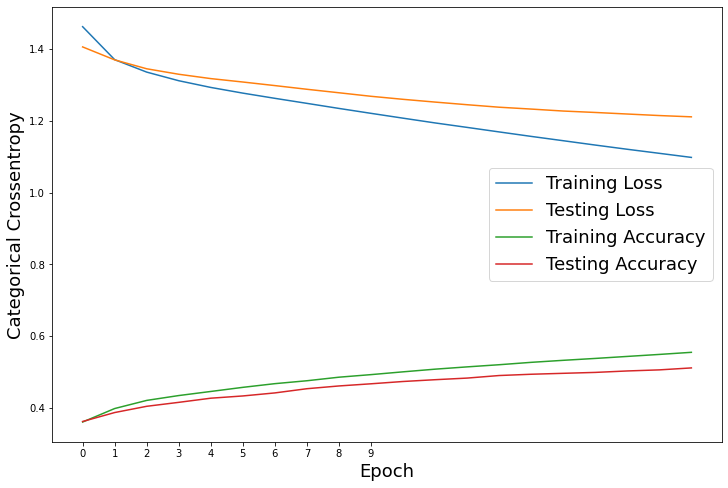

In [75]:
# Check out our train loss and test loss over epochs.
train_loss = hist.history['loss']
test_loss = hist.history['val_loss']

train_acc = hist.history['accuracy']
test_acc = hist.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Testing Accuracy')


# Set title
# plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(np.arange(10), np.arange(10))

plt.legend(fontsize = 18);

Evaluate model accuracy

In [38]:
score = clf.score(X_test, y_test, verbose=0)    
print('model accuracy: {}'.format(score))

model accuracy: 0.44918006658554077


Visualize model architecture

Finally, save model

In [ ]:
from keras.utils import plot_model

plot_model(clf.model, to_file='tmp/model_structure.png', show_shapes=True)

In [ ]:
clf.model.save('/tmp/keras_mlp.h5')